# Jonas Hansen | Math 157 Final Project | May 15, 2022
# Frequency Analysis Wordle Solver

In [1]:
# Importing libraries
import numpy as np
import os
import pandas as pd
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import time

In [ ]:
# Loading list of all 5-Letter words
with open('five_word_list.txt', 'r') as f:
    words_all = f.readlines()
    words_all = [x.lower().strip() for x in words_all]

In [ ]:
# Loading list of all Wordle solution words
with open('wordle_words.txt', 'r') as f:
    wordle_words = f.readlines()
    wordle_words = [x.lower().strip() for x in wordle_words]

In [ ]:
# Global constants
max_guesses = 10
word_len = 5

## Computing Character Frequencies and Distributions

In [ ]:
def char_position_freq(list_of_words, char_pos):
    """
    Description: Calculates the frequency that each letter in the alphabet
    appears in a certain location in a word.
    
    Inputs:
        list_of_words: list of all five-letter words.
        char_pos: the position of a letter within a word.
    
    Output:
        pos_freq_df = pandas DataFrame with the positional frequency of letters.
    """        
    # Sorting words for indexing
    words = [word for word in list_of_words if len(word) > char_pos]
    list_of_letters = [word[char_pos] for word in words]
    
    # Using collections.Counter to count the letter frequency across all words 
    freq_vals = Counter(list_of_letters)
    
    # Saving to pandas Dataframe
    pos_freq_df = pd.DataFrame.from_dict(freq_vals, columns=["count"], 
                                         orient="index").sort_values("count", ascending=False)
    num_letter = pos_freq_df["count"].sum()
    pos_freq_df[f'freq_pos{char_pos}'] = pos_freq_df["count"].apply(lambda num: (num / num_letter))
    pos_freq_df.drop("count", axis=1, inplace=True)

    return pos_freq_df

In [ ]:
def char_freq(list_of_words):
    """
    Description: Calculates the frequency of each letter across all words.
    
    Inputs:
        list_of_words: list of all five-letter words.
    
    Output:
        char_freq_df = pandas DataFrame with the frequency distribution of letters.
    """
    # Counting letter frequency using collections.Counter
    list_of_letters = [x for word in list_of_words for x in word]
    freq_vals = Counter(list_of_letters)
    
    # Saving to pandas DataFrame
    char_freq_df = pd.DataFrame.from_dict(freq_vals, columns=["count"], 
                                          orient="index").sort_values("count", ascending=False)
    num_letters = char_freq_df["count"].sum()
    char_freq_df["freq"] = char_freq_df["count"].apply(lambda num: (num / num_letters))
    
    return char_freq_df

In [ ]:
def char_and_pos_freq(list_of_words):
    """
    Description: Combines letter and positional frequency DataFrames
    
    Inputs:
        list_of_words: list of all five-letter words.
    
    Output:
        char_pos_freq_df = pandas DataFrame with the frequency distribution of 
                           letters and their positions.
    """
    # Adding position frequency DataFrame to letter frequency DataFrame for five positions
    char_pos_freq_df = char_freq(list_of_words)
    for i in range(word_len):
        pos_freq_df = char_position_freq(list_of_words, i)
        char_pos_freq_df = pd.concat([char_pos_freq_df, pos_freq_df], axis=1)
        
    return char_pos_freq_df

## Finding The Best Words to Guess Based on Hints

In [ ]:
def remove_repeats(list_of_words):
    """
    Description: Filters out words with repeated letters so more information can
                 be learned about more letters per guess.

    Inputs:
        list_of_words: list of all five-letter words.
    
    Output:
        no_repeat_words = list of words with no repeating letters.
    """
    # Asserting equal word length
    assert len(set([len(word) for word in list_of_words])) == 1
    word_len = len(list_of_words[0])
    no_repeat_words = [word for word in list_of_words if len(set(list(word))) == len(word)]
    
    return no_repeat_words

In [ ]:
def words_after_hints(list_of_words, gray_letters, yellow_letters=None, green_pos=None, yellow_pos=None):
    """
    Description: Filters out words based on game hints.

    Inputs:
        list_of_words: list of all five-letter words.
        gray_letters: letters to exclude.
        yellow_letters: letters to include.
        green_pos: true letter positions.
        yellow_pos: incorrect letter positions.
    
    Output:
        filtered_words = trimmed list of words after implementing game hints.
    """
    filtered_words = list_of_words
    for letter in gray_letters:
        filtered_words = [word for word in filtered_words if letter not in word]
        
    if yellow_letters is not None:
        for letter in yellow_letters:
            filtered_words = [word for word in filtered_words if letter in word]
            
    if green_pos is not None:
        for pos, letter in green_pos.items():
            filtered_words = [word for word in filtered_words if word[pos] == letter]
    
    if yellow_pos is not None:
        for pos, letter in yellow_pos.items():
            filtered_words = [word for word in filtered_words if word[pos] not in letter]

    return filtered_words

In [ ]:
def best_guess(list_of_words, pos_scan=None):
    """
    Description: Returns the suggested words based on the above frequency
                 analysis.

    Inputs:
        list_of_words: list of all five-letter words.
        pos_scan: set of analyzed letter positions.
    
    Output:
        best_guess_list = list of optimal words to guess.
    """     
    # Asserting equal word length
    assert len(set([len(word) for word in list_of_words])) == 1
    word_len = len(list_of_words[0])

    # Getting pandas DataFrame of letter and position frequencies
    char_pos_freq_df = char_and_pos_freq(list_of_words)

    # Initialize set of letter positions to be analyzed
    if pos_scan is None:
        pos_scan = set()
        
    pos_freqs = []
    for i in range(len(list_of_words[0])):
        if i not in pos_scan:
            pos_freqs.append(f'freq_pos{i}')
    
    # Getting stats on DataFrame column with the highest distribution
    max_column = char_pos_freq_df.loc[:,pos_freqs].max().idxmax() 
    max_freq_index = char_pos_freq_df.loc[:,max_column].idxmax()
    max_freq_val = char_pos_freq_df.loc[:,max_column].max()
    
    # Cut down list of words to words with optimal frequencies
    best_pos = int(max_column.split('freq_pos')[-1])
    best_guesses = [word for word in list_of_words if word[best_pos] == max_freq_index]
    pos_scan.add(best_pos)
    
    if len(pos_scan) < word_len:
        best_guess_list = best_guess(best_guesses, pos_scan=pos_scan)
        best_guess_list.extend(best_guesses)
        return best_guess_list
    else:
        best_guess_list = best_guesses
        return best_guess_list

## Some Statistics

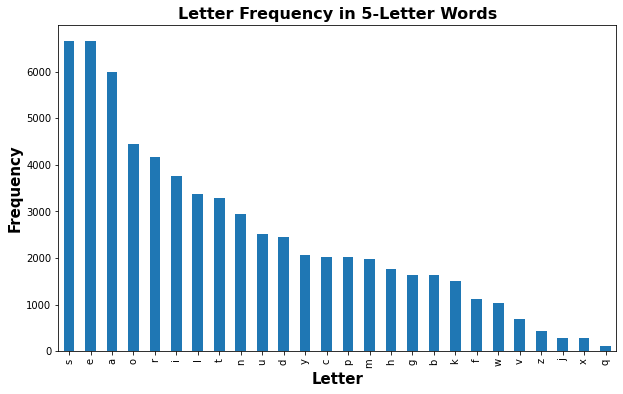

In [ ]:
# Plotting the frequency distribution of letters in 5-letter words
fig = plt.figure(figsize=(10,6))

char_freq(words_all)['count'].plot(kind="bar")
plt.title("Letter Frequency in 5-Letter Words", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=15, fontweight="bold")
plt.xlabel('Letter', fontsize=15, fontweight="bold")
plt.show()

In [ ]:
# Displaying pandas DataFrame of letters, their relative frequencies, and how 
    # often they appear in each position of a 5-letter word
char_and_pos_freq(words_all)

,count,freq,freq_pos0,freq_pos1,freq_pos2,freq_pos3,freq_pos4
s,6665,0.102760,0.120644,0.007169,0.041088,0.039778,0.305119
e,6662,0.102714,0.023358,0.125501,0.067993,0.179386,0.117330
a,5990,0.092353,0.056815,0.174453,0.095282,0.082794,0.052421
o,4438,0.068424,0.020197,0.161579,0.076549,0.053808,0.029988
r,4158,0.064107,0.048412,0.072464,0.092353,0.055427,0.051881
i,3759,0.057956,0.012720,0.106614,0.081021,0.067838,0.021585
l,3371,0.051973,0.044480,0.053885,0.065372,0.059436,0.036694
t,3295,0.050802,0.062828,0.018424,0.047487,0.069226,0.056044
n,2952,0.045513,0.025054,0.026596,0.074314,0.060746,0.040857
u,2511,0.038714,0.014570,0.091505,0.051418,0.030913,0.005165


## Playing the Game

In [ ]:
def calculate_hints(guess, solution):
    '''
    Description: returns hint pattern by comparing guess word to solution words (0 = gray letter, 1 = yellow
                 letter, 2 = green letter).
    Inputs:
        guess: the guess word.
        solution: the Wordel solution word.
    Output:
        tuple(pattern): tuple of hint pattern.
    '''
    incorrect = [idx for idx, val in enumerate(guess) if val != solution[idx]]
    counts = Counter(solution[i] for i in incorrect)
    pattern = [2] * 5
    for i in incorrect:
        char = guess[i]
        if counts[char] > 0:
            pattern[i] = 1
            counts[char] -= 1
        else:
            pattern[i] = 0
    
    return tuple(pattern)

In [ ]:
# Finding best opening word to use for every game
repeat_free_words = remove_repeats(words_all)
opening_guess = best_guess(repeat_free_words)[0]
print("Best opener:", opening_guess)

Best opener: bares


In [ ]:
freq_num_guesses_list = []
def play_frequency_wordle(solution_word, guess_word):
    # Initializing our letter and position lists
    gray_letters = []
    yellow_letters = []
    green_pos = defaultdict(str)
    yellow_pos = defaultdict(list)

    # Iterating process through each round
    for round in range(max_guesses):
        print("Round", round+1, "\n------------")
        outcome = calculate_hints(guess_word, solution_word)
        print("Guessing:", guess_word)
        print("Hint:", outcome)
        if outcome == (2,2,2,2,2):
            print("--> Yay! Word is:", guess_word, "| Number of Guesses:", round+1, "\n")
            freq_num_guesses_list.append(round+1)
            break
        
        for i, result in enumerate(outcome):
            if result == 0:
                gray_letters.append(guess_word[i])
            elif result == 2:
                yellow_letters.append(guess_word[i])
                green_pos[i] = guess_word[i]
            elif result == 1:
                yellow_letters.append(guess_word[i])
                yellow_pos[i].append(guess_word[i])

            yellow_letters = set(yellow_letters)
            gray_letters = set(gray_letters)

            gray_letters = gray_letters.difference(yellow_letters)
            yellow_letters = list(yellow_letters)
            gray_letters = list(gray_letters)
            
        trimmed_word_list = words_after_hints(words_all, gray_letters=gray_letters, 
                                            yellow_letters=yellow_letters,
                                            green_pos=green_pos,
                                            yellow_pos=yellow_pos)
        
        if round < 1:
            trimmed_word_list = remove_repeats(trimmed_word_list)
        
        # Return list of best unique words
        guesses = list(dict.fromkeys(best_guess(trimmed_word_list)))
        print(len(trimmed_word_list), "words remaining")
        print("Best Next Guesses:", guesses, "\n")
        if guesses[0] == guess_word:
            guess_word = guesses[1]
        else:
            guess_word = guesses[0]

In [ ]:
play_frequency_wordle("tipsy", opening_guess)

Round 1 
------------
Guessing: bares
Hint: (0, 0, 0, 0, 1)
263 words remaining
Best Next Guesses: ['stony', 'stond', 'stong', 'stonk', 'stomp', 'stock', 'stoic', 'stogy', 'stoln', 'stoun', 'stoup', 'stown', 'stowp', 'snout', 'shown', 'showy', 'sloth', 'shock', 'spoil', 'spout', 'smock', 'scold', 'smoky', 'shout', 'scowl', 'scout', 'snowy', 'scody', 'scoug', 'scoup', 'scowp', 'shogi', 'shoji', 'showd', 'shoyu', 'skody', 'sloid', 'slojd', 'slopy', 'sloyd', 'smolt', 'smout', 'smowt', 'snowk', 'swoln', 'swopt', 'swoun', 'stink', 'spicy', 'sonic', 'slump', 'slung', 'stick', 'sting', 'skimp', 'stuck', 'study', 'spilt', 'slick', 'swift', 'snuck', 'spiny', 'scion', 'stung', 'sound', 'silky', 'solid', 'shunt', 'slimy', 'south', 'suing', 'shift', 'shuck', 'sulky', 'synod', 'swung', 'sixth', 'spunk', 'shiny', 'stump', 'swing', 'sight', 'sixty', 'split', 'slunk', 'sling', 'spiky', 'smith', 'slink', 'stunk', 'schmo', 'schul', 'sclim', 'scudi', 'scudo', 'scuft', 'sculk', 'sculp', 'shily', 'shtik', 

In [ ]:
play_frequency_wordle("hasty", opening_guess)

Round 1 
------------
Guessing: bares
Hint: (0, 2, 0, 0, 1)
69 words remaining
Best Next Guesses: ['salon', 'salop', 'salty', 'salvo', 'salic', 'salix', 'salmi', 'salto', 'salut', 'saint', 'sadly', 'savoy', 'saucy', 'satin', 'sandy', 'sadhu', 'sagum', 'saick', 'saith', 'sajou', 'sakti', 'samfu', 'sampi', 'sangh', 'sango', 'sanko', 'santo', 'sapid', 'sauch', 'saugh', 'sault', 'saunt', 'savin', 'sayid', 'sayon', 'nasty', 'hasty', 'palsy', 'mason', 'daisy', 'waist', 'patsy', 'pansy', 'pasty', 'canso', 'canst', 'casky', 'dashi', 'dashy', 'fasci', 'fasti', 'fatso', 'gadso', 'gaspy', 'gawsy', 'hadst', 'maist', 'mashy', 'masty', 'mausy', 'mayst', 'nashi', 'pashm', 'paysd', 'taish', 'tansy', 'vasty', 'washy', 'waspy'] 

Round 2 
------------
Guessing: salon
Hint: (1, 2, 0, 0, 0)
38 words remaining
Best Next Guesses: ['tasty', 'hasty', 'pasty', 'masty', 'vasty', 'gassy', 'casky', 'dashy', 'gaspy', 'hashy', 'mashy', 'massy', 'paspy', 'washy', 'waspy', 'pasta', 'dashi', 'fasci', 'fasti', 'hasta',

In [ ]:
def main():
    game_num = 1
    for wordle_word in wordle_words:
        print("-------- GAME", game_num, "--------")
        play_frequency_wordle(wordle_word, guess_word=opening_guess)
        game_num += 1

In [ ]:
start_time = time.time()
main()
end_time = time.time()
print("\n\n\nRuntime =", end_time - start_time, "seconds")

Streaming output truncated to the last 5000 lines.
1 words remaining
Best Next Guesses: ['untie'] 

Round 5 
------------
Guessing: untie
Hint: (2, 2, 2, 2, 2)
--> Yay! Word is: untie | Number of Guesses: 5 

-------- GAME 2162 --------
Round 1 
------------
Guessing: bares
Hint: (0, 0, 0, 0, 0)
518 words remaining
Best Next Guesses: ['poncy', 'pongy', 'ponty', 'conky', 'fonly', 'honky', 'jonty', 'monty', 'wonky', 'lofty', 'howdy', 'godly', 'moldy', 'hotly', 'comfy', 'pouty', 'downy', 'doily', 'dowly', 'folky', 'goldy', 'gothy', 'gouty', 'jocky', 'jolty', 'jowly', 'mochy', 'mothy', 'noily', 'nowty', 'pocky', 'podgy', 'powny', 'tocky', 'touzy', 'towny', 'towzy', 'pound', 'moult', 'point', 'mount', 'could', 'month', 'found', 'vouch', 'youth', 'vomit', 'count', 'mound', 'tough', 'toxin', 'doing', 'cough', 'dough', 'donut', 'would', 'pouch', 'touch', 'notch', 'young', 'motif', 'mogul', 'logic', 'joint', 'topic', 'toxic', 'tonic', 'wound', 'mouth', 'hound', 'login', 'coign', 'colin', 'comix

## Results

In [ ]:
freq_runtime = 766.2604446411133  # seconds

In [3]:
freq_num_guesses_list = np.loadtxt("results/freq_num_guesses_list.txt")

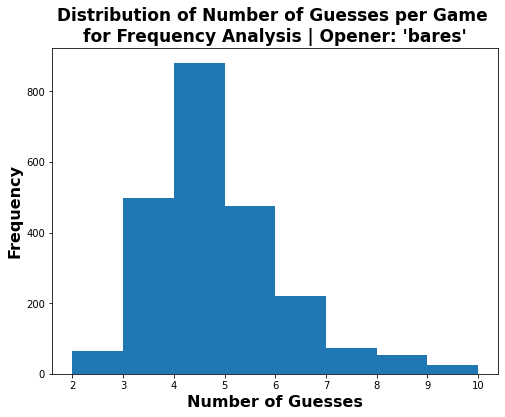

In [5]:
# Plotting guess distribution
fig = plt.figure(figsize=(8,6))
plt.hist(freq_num_guesses_list, 8)
plt.title("Distribution of Number of Guesses per Game \nfor Frequency Analysis | Opener: 'bares'", 
          fontsize=17, fontweight="bold")
plt.xlabel("Number of Guesses", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.show()

In [ ]:
# Average number of guesses
freq_guess_mean = np.mean(freq_num_guesses_list)
print("Mean Number of Guesses per Game =", freq_guess_mean)

Mean Number of Guesses per Game = 4.377729257641922


In [ ]:
freq_num_guesses_txt = open("freq_num_guesses.txt", "w")
for i in freq_num_guesses_list:
    freq_num_guesses_txt.write(str(i) + "\n")
freq_num_guesses_txt.close()